<a href="https://colab.research.google.com/github/manojmandal27/RAG_with_OpenAI_LLMs/blob/main/Step_1_LLM_RAG_with_RBAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement:
Development of a Retrieval-Augmented Generation (RAG) System with User Access Control for Knowledge-Based Question Answering

In many organizations, information is stored in the form of documents such as reports, manuals, and research papers in PDF ,text format. These documents often contain valuable insights that employees or stakeholders need to access for informed decision-making. However, retrieving specific information from large collections of documents is time-consuming and inefficient without an intelligent system.

# Goal
The goal is to develop a Retrieval-Augmented Generation (RAG) system that can provide precise answers to user queries by retrieving and generating responses based on the knowledge contained in uploaded  documents. Additionally, user access control must be implemented to restrict access to specific documents and functionalities based on user roles, enhancing data protection and ensuring that sensitive information is not accessed by unauthorized users.

# Steps
### 1.Document Upload and Management:
Enable users to upload multiple PDF documents through an interactive user interface. Extract and process the text from the uploaded documents for use in the RAG system. Document Chunking and Embedding:
### 2.Chunking
Split documents into manageable chunks for efficient processing and retrieval.
### 3.Vector embeddings
Create vector embeddings for document chunks and store them in a vector database for fast and accurate search capabilities.
### 4.Retrieval
Retrive the information based on the documents uploaded and access provided
### 5.User Access Control
Implement role-based access control (RBAC) to ensure users have different levels of access (e.g., admin, researcher, end-user). Authenticate and authorize users through secure methods to restrict or allow access to specific files and system features. Retrieval-Augmented Generation:
### 6.Use OpenAi LLM via API
Integrate a large language model (LLM) to generate responses using retrieved document chunks. Refine user queries before sending them to the LLM for more relevant and accurate answers. Experiment with and without Maximal Marginal Relevance (MMR) to optimize the retrieval process. User-Friendly Interface:
### 7.User Interface
Create a web-based interface using tools such as Gradio or Streamlit to allow users to upload files, input queries, and receive responses in an intuitive way.

# Install Dependencies and import libraries

In [ ]:
%%capture
!pip -q install faiss-cpu
!pip -q install langchain_community
!pip -q install langchain pyjwt bcrypt PyPDFLoader
!pip -q install openai
!pip -q install langchain-openai
!pip -q install langchain-core
!pip -q install langchain-community
!pip -q install sentence-transformers
!pip -q install langchain-huggingface
!pip -q install langchain-chroma
#!pip -q install chromadb
!pip -q install PyPDF2
#!pip -q install tiktoken
!pip -q install gradio

In [ ]:
from langchain_community.document_loaders import TextLoader
import faiss
import numpy as np
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
from langchain.chains import create_retrieval_chain
from langchain_core.prompts import ChatPromptTemplate
from sklearn.metrics.pairwise import cosine_similarity
import gradio as gr
import jwt
import datetime
import bcrypt
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.chains import RetrievalQA
from langchain.docstore.document import Document
from io import BytesIO
from PyPDF2 import PdfReader

## Loads Documents:
The code begins by loading text files into a list called docs.
It uses the TextLoader class from langchain for this purpose.
## Combine and Splits:

1.Combines all the loaded documents and splits them into smaller chunks using the RecursiveCharacterTextSplitter.

2.For efficient processing and to allow for more targeted retrieval of information later.

## Chunk Size and Overlap:
This overlap helps to ensure that context is preserved between chunks.
## Stores as Documents:
The resulting chunks are stored in a list called documents, where each chunk is represented as a Document object. These Document objects are a standard way to represent text in langchain and contain the text content as well as metadata about the source of the text.

In [ ]:
docs = []
loader = TextLoader("HR.txt")
docs.extend(loader.load())
loader = TextLoader("Sales.txt")
docs.extend(loader.load())
loader = TextLoader("Tech.txt")
docs.extend(loader.load())
loader = TextLoader("Marketing.txt")
docs.extend(loader.load())

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=300)
documents = text_splitter.split_documents(docs)

The below code associates each document chunk with a specific role (HR, Sales, Tech, Marketing) based on the source file name. It stores this role information in the document's metadata for access control.

In [ ]:
text_files = {
    "HR.txt": ["HR"],
    "Sales.txt": ["Sales"],
    "Tech.txt": ["Tech"],
    "Marketing.txt": ["Marketing"],
}

for doc in documents:
    doc.metadata["role"] = text_files[doc.metadata["source"]]

In [ ]:
# prompt: check the content of file uploaded

# You can check the content of the uploaded files using the following methods:

# Method 1: Print the content of the 'documents' list.
# This will print the text content and metadata of each document chunk.
# for doc in documents:
#     print(doc)

# Method 2: Access and print specific document content or metadata.
# Example: print the content of the first document chunk.
# print(documents[0].page_content)

# Example: print the metadata of the first document chunk.
# print(documents[0].metadata)


# Method 3: Check the number of documents and chunks
print(f"Total number of documents: {len(documents)}")

# Example: Print the source of each document.
for i, doc in enumerate(documents):
    print(f"Document {i+1} Source: {doc.metadata['source']}")
    print(f"Document {i+1} Role: {doc.metadata['role']}")


# Method 4:  Write the document content to a file for review
with open("combined_documents.txt", "w") as f:
    for doc in documents:
      f.write(f"Source: {doc.metadata['source']}\n")
      f.write(f"Role: {doc.metadata['role']}\n")
      f.write(f"Content:\n{doc.page_content}\n\n")

print("Combined document content written to combined_documents.txt")

Total number of documents: 67
Document 1 Source: HR.txt
Document 1 Role: ['HR']
Document 2 Source: HR.txt
Document 2 Role: ['HR']
Document 3 Source: HR.txt
Document 3 Role: ['HR']
Document 4 Source: HR.txt
Document 4 Role: ['HR']
Document 5 Source: HR.txt
Document 5 Role: ['HR']
Document 6 Source: HR.txt
Document 6 Role: ['HR']
Document 7 Source: HR.txt
Document 7 Role: ['HR']
Document 8 Source: HR.txt
Document 8 Role: ['HR']
Document 9 Source: HR.txt
Document 9 Role: ['HR']
Document 10 Source: HR.txt
Document 10 Role: ['HR']
Document 11 Source: Sales.txt
Document 11 Role: ['Sales']
Document 12 Source: Sales.txt
Document 12 Role: ['Sales']
Document 13 Source: Sales.txt
Document 13 Role: ['Sales']
Document 14 Source: Sales.txt
Document 14 Role: ['Sales']
Document 15 Source: Sales.txt
Document 15 Role: ['Sales']
Document 16 Source: Sales.txt
Document 16 Role: ['Sales']
Document 17 Source: Sales.txt
Document 17 Role: ['Sales']
Document 18 Source: Sales.txt
Document 18 Role: ['Sales']
Docu

In [ ]:
# Read OpenAI key from Colab Secrets

from google.colab import userdata
import openai # Import the openai module
import chromadb
import os  # Import the os module

api_key = userdata.get('OA_API')           # <-- change this as per your secret's name
os.environ['OPENAI_API_KEY'] = api_key
openai.api_key = os.getenv('OPENAI_API_KEY')

## Initializes OpenAI Embeddings:
embeddings_model = OpenAIEmbeddings() creates an instance of the OpenAIEmbeddings class, which is used to generate embeddings (numerical representations) of text using OpenAI's models.
## Generates and Extends Embeddings:
The code iterates through each document (doc in documents). For each document, it generates an embedding using embeddings_model.embed_query(). Then, it calculates a numerical value (role_value) based on the document's role (HR, Sales, Tech, Marketing), and extends the embedding vector by adding this role_value.
## Creates Embedding Array:
Finally, embedding_array = np.array(embedding_vectors) converts the list of extended embedding vectors (embedding_vectors) into a NumPy array for efficient storage and further processing. This array now holds the numerical representations of your documents, enriched with role information.

In [ ]:
import numpy as np

embeddings_model = OpenAIEmbeddings()  # OpenAIEmbeddings is assigned to embeddings_model
embedding_vectors = []

for doc in documents:
    embedding = embeddings_model.embed_query(doc.page_content)
    role_value = 0
    if "HR" in doc.metadata["role"]:
        role_value += 1
    if "Sales" in doc.metadata["role"]:
        role_value += 2
    if "Tech" in doc.metadata["role"]:
        role_value += 3
    if "Marketing" in doc.metadata["role"]:
        role_value += 4

    extended_vector = np.concatenate([embedding, [role_value]])
    embedding_vectors.append(extended_vector)

embedding_array = np.array(embedding_vectors)

<ipython-input-9-b3bbb87deeb2>:3: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embeddings_model = OpenAIEmbeddings()  # OpenAIEmbeddings is assigned to embeddings_model


Below lines prepare your data for efficient similarity search using FAISS. The code determines the dimensions of your embedding vectors, creates a suitable index, and adds your data to it. This setup enables fast retrieval of relevant documents based on user queries and their roles.


In [ ]:
embedding_dim = len(embedding_vectors[0]) - 1
index = faiss.IndexFlatL2(embedding_dim + 1)
index.add(embedding_array)

## Custom Retriever:
Defines a class MetadataFAISSRetriever to manage document retrieval based on content and user role.
## Initialization:
Stores FAISS index, embedding model, and documents within the retriever object.
Role-Based Query: retrieve function converts user role into a numerical value, adding it to the query's embedding.
FAISS Search: Uses FAISS index to find the top k (here, 5) nearest document embeddings to the query embedding.
## Access Control:
Filters retrieved documents, only returning those accessible to the user's role.

In [ ]:
class MetadataFAISSRetriever:
    def __init__(self, index, embedding_model, documents):
        self.index = index
        self.embedding_model = embedding_model
        self.documents = documents

    def retrieve(self, query, user_role):
        query_embedding = self.embedding_model.embed_query(query)

        if user_role == "HR":
            query_role_value = int(format(1, '016b'), 2)
        elif user_role == "Sales":
            query_role_value = int(format(2, '016b'), 2)
        elif user_role == "Tech":
            query_role_value = int(format(3, '016b'), 2)
        elif user_role == "Marketing":
            query_role_value = int(format(4, '016b'), 2)
        else:
            query_role_value = int(format(5, '016b'), 2)

        query_vector = np.concatenate([query_embedding, [query_role_value]])
        distances, indices = self.index.search(query_vector.reshape(1, embedding_dim + 1), k=5)

        retrieved_docs = []
        for i in indices[0]:
            if i < len(self.documents):
                doc_role_value = 0
                if "HR" in self.documents[i].metadata["role"]:
                    doc_role_value += int(format(1, '016b'), 2)
                if "Sales" in self.documents[i].metadata["role"]:
                    doc_role_value += int(format(2, '016b'), 2)
                if "Tech" in self.documents[i].metadata["role"]:
                    doc_role_value += int(format(3, '016b'), 2)
                if "Marketing" in self.documents[i].metadata["role"]:
                    doc_role_value += int(format(4, '016b'), 2)
                if query_role_value & doc_role_value:
                    retrieved_docs.append(self.documents[i])

        return retrieved_docs

    # Ensure this function has the same indentation level as the __init__ and retrieve methods
    def score_documents(self, query, retrieved_docs):
        query_embedding = np.array(self.embedding_model.embed_query(query)).reshape(1, -1)

        doc_embeddings = []
        for doc in retrieved_docs:
            doc_embedding = np.array(self.embedding_model.embed_query(doc.page_content))
            doc_embeddings.append(doc_embedding)
        doc_embeddings = np.array(doc_embeddings)

        similarities = cosine_similarity(query_embedding, doc_embeddings).flatten()
        scored_docs = [(doc, similarity) for doc, similarity in zip(retrieved_docs, similarities)]
        scored_docs.sort(key=lambda x: x[1], reverse=True)


        top_docs = [doc for doc, _ in scored_docs[:10]]
        return top_docs

Below creates a retriever object using FAISS index, embeddings, and documents for role-based retrieval.

In [ ]:
retriever = MetadataFAISSRetriever(index, embeddings_model, documents)

Define the user roles and input the current role for response
###Change the role and rerun the code for other roles and quesries

In [ ]:
user_role = 'HR'  # Current user's role
query = "What does the labour laws in India cover?"

if user_role == 'HR':
    role_str = "Role: ['HR'], so you are in HR."
if user_role == 'Sales':
    role_str = "Role: ['Sales'], so you are in Sales."
elif user_role == 'Tech':
    role_str = "Role: ['Tech'], so you are in Tech."
elif user_role == 'Marketing':
    role_str = "Role: ['Marketing'], so you are in Marketing."


Below code prepares the system to use a large language model (gpt-4o) to generate answers to user queries, incorporating document context and user roles to guide the model and enforce access restrictions.

## Installs & Imports:
Installs the langchain package and imports necessary modules for working with LLMs
## Defines Prompt:
Creates a prompt template instructing the LLM to answer questions based on provided documents and user roles, ensuring access control.
## Assembles Prompt:
Combines prompt components into a finalPrompt, preparing it for use in the retrieval chain.

In [ ]:
#!pip install langchain --upgrade
from langchain.llms import OpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.chat_models import ChatOpenAI

# Update the llm instantiation to use ChatOpenAI:
llm = ChatOpenAI(model_name="gpt-4o", temperature=0.5)

promptList = []
promptPart1 = """
You are a system designed to provide information based on documents available to either the HR team, the Sales team, the Marketing team , the Tech team. Your task is to answer the user's question using only the context provided from the documents.
"""
promptPart2 = """
Ensure that:
1. If the relevant document(s) are accessible to the user's role, provide only the information directly from the document(s) that answers the query. Do not include any additional context or details that are not present in the document(s).
2. If the relevant document(s) are not accessible to the user's role, strictly state: 'Sorry, I can't share this information as you do not have access.'
3. Avoid adding any extra details, speculative information, prior content, or context beyond what is directly contained in the document(s).
4. If the document is accessible by multiple roles, validate access accordingly, but do not infer or combine roles.

**Important**
- Provide a response that is solely based on the document content relevant to the query.
- Exclude any information that is not present in the document(s) provided.
<context>
{context}
</context>
Question: {input}
"""
promptList.append (promptPart1)
promptList.append (role_str)
promptList.append (promptPart2)
finalPrompt = "".join (promptList)
prompt = ChatPromptTemplate.from_template (finalPrompt)

In [ ]:
from langchain.chains.combine_documents import create_stuff_documents_chain
document_chain = create_stuff_documents_chain(llm, prompt)

In [ ]:
retrieved_docs = retriever.retrieve(query, user_role)
most_relevant_docs = retriever.score_documents(query, retrieved_docs)

response = document_chain.invoke({"input": query, "context": most_relevant_docs})

print(response)

The Labour Laws in India cover a broad spectrum of aspects, including minimum wages, working hours, termination procedures, and employee benefits.


In [ ]:
# User database with hashed passwords (for demonstration purposes)
users_db = {
    "hr": {
        "password": bcrypt.hashpw("hr123".encode('utf-8'), bcrypt.gensalt()),
        "roles": ["admin"]
    },
    "sales": {
        "password": bcrypt.hashpw("sales123".encode('utf-8'), bcrypt.gensalt()),
        "roles": ["user1"]
    },
    "marketing": {
        "password": bcrypt.hashpw("marketing123".encode('utf-8'), bcrypt.gensalt()),
        "roles": ["user2"]
    },
    "tech": {
        "password": bcrypt.hashpw("tech123".encode('utf-8'), bcrypt.gensalt()),
        "roles": ["user3"]
    }
}


# Code for creating Gradio Interface

In [ ]:
import gradio as gr
import bcrypt  # Make sure bcrypt is imported

def predict(query, user_role):
    # Assuming retriever, document_chain, and other necessary variables are defined in the global scope as in your original code

    if user_role == 'HR':
        role_str = "Role: ['HR'], so you are in HR."
    elif user_role == 'Sales':
        role_str = "Role: ['Sales'], so you are in Sales."
    elif user_role == 'Tech':
        role_str = "Role: ['Tech'], so you are in Tech."
    elif user_role == 'Marketing':
        role_str = "Role: ['Marketing'], so you are in Marketing."
    else:
        role_str = "Invalid Role"

    promptList = []
    promptPart1 = """
    You are a system designed to provide information based on documents available to either the HR team, the Sales team, the Marketing team , the Tech team. Your task is to answer the user's question using only the context provided from the documents.
    """
    promptPart2 = """
    Ensure that:
    1. If the relevant document(s) are accessible to the user's role, provide only the information directly from the document(s) that answers the query. Do not include any additional context or details that are not present in the document(s).
    2. If the relevant document(s) are not accessible to the user's role, strictly state: 'Sorry, I can't share this information as you do not have access.'
    3. Avoid adding any extra details, speculative information, prior content, or context beyond what is directly contained in the document(s).
    4. If the document is accessible by multiple roles, validate access accordingly, but do not infer or combine roles.

    **Important**
    - Provide a response that is solely based on the document content relevant to the query.
    - Exclude any information that is not present in the document(s) provided.
    <context>
    {context}
    </context>
    Question: {input}
    """
    promptList.append(promptPart1)
    promptList.append(role_str)
    promptList.append(promptPart2)
    finalPrompt = "".join(promptList)
    prompt = ChatPromptTemplate.from_template(finalPrompt)

    retrieved_docs = retriever.retrieve(query, user_role)
    most_relevant_docs = retriever.score_documents(query, retrieved_docs)

    # Update the chain invocation using the new prompt
    response = document_chain.invoke({"input": query, "context": most_relevant_docs})
    return response

def login_fn(username, password):
    """Validates user credentials against the users_db."""
    user = users_db.get(username)
    if user and bcrypt.checkpw(password.encode('utf-8'), user["password"]):
        # Successful login
        return True, "Login successful!", ""  # Return True for success, message, and clear error
    else:
        # Invalid login
        return False, "", "Invalid username or password."  # Return False for failure, clear message, and error


# Define the main Gradio Blocks
with gr.Blocks() as demo:
    # Input components for login
    with gr.Row():
        username_input = gr.Textbox(label="Username", placeholder="Enter your username")
        password_input = gr.Textbox(label="Password", placeholder="Enter your password", type="password")

    # Button for login
    login_button = gr.Button("Login")

    # Initially hide the main interface
    iface = gr.Interface(
        fn=predict,
        inputs=[
            gr.Textbox(label="Enter your query"),
            gr.Radio(["HR", "Sales", "Tech", "Marketing"], label="Select your role", value="HR")
        ],
        outputs=gr.Textbox(label="Response"),
        title="Document QA System",
        description="Ask questions related to the provided documents.",
        visible=False  # Hide initially
    )

    # Display message for invalid login
    invalid_login_message = gr.Textbox(label="Login Status", value="Please log in.", visible=False)

    # Define outputs for the login button click
    login_button.click(
        login_fn,
        inputs=[username_input, password_input],
        outputs=[iface, invalid_login_message, gr.Textbox(label="Login Status", visible=False)]
    )

demo.launch(share=True, debug=True) # Added debug=True

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://2ef04033cce66fba25.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/queueing.py", line 624, in process_events
    response = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 323, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 2025, in process_api
    data = await self.postprocess_data(block_fn, result["prediction"], state)
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1826, in postprocess_data
    raise InvalidComponentError(
gradio.exceptions.InvalidComponentError: <class 'gradio.interface.Interface'> Component not a valid output component.


## The code is designed to update the embeddings and FAISS index if there are changes in the original documents or their associated roles. This ensures the RAG system stays up-to-date with the latest information.

In [ ]:

for i, doc in enumerate(documents):
    file_name = doc.metadata['source']

    # Reload the document using TextLoader
    loader = TextLoader(file_name)
    new_documents = loader.load()
    new_content = new_documents[0].page_content

    # Determine the new role value
    new_role_value = 0
    roles = text_files.get(file_name, '')
    if "HR" in roles:
        new_role_value += 1
    if "Sales" in roles:
        new_role_value += 2
    if "Tech" in roles:
        new_role_value += 3
    if "mareting" in roles:
        new_role_value += 4

    # Check if the content or role has changed compared to the existing state
    embedding_model = OpenAIEmbeddings() # Using OpenAI embeddings
    current_embedding = embedding_model.embed_query(new_content)
    extended_vector = np.concatenate([current_embedding, [new_role_value]])
    extended_vector = np.array(extended_vector, dtype=np.float32)

    if (i < len(embedding_vectors) and
        not np.array_equal(embedding_vectors[i], extended_vector)):
        # Update the embedding in the list
        if i < len(embedding_vectors):
            embedding_vectors[i] = extended_vector
        else:
            embedding_vectors.append(extended_vector)
        # Rebuild the entire index
        index.reset()
        index.add(np.array(embedding_vectors, dtype=np.float32))
    else:
        print(f"No changes detected for document chunk {i}.")

No changes detected for document chunk 0.
No changes detected for document chunk 1.
No changes detected for document chunk 2.
No changes detected for document chunk 3.
No changes detected for document chunk 4.
No changes detected for document chunk 5.
No changes detected for document chunk 6.
No changes detected for document chunk 7.
No changes detected for document chunk 8.
No changes detected for document chunk 10.
No changes detected for document chunk 11.
No changes detected for document chunk 12.
No changes detected for document chunk 13.
No changes detected for document chunk 14.
No changes detected for document chunk 15.
No changes detected for document chunk 16.
No changes detected for document chunk 18.
No changes detected for document chunk 19.
No changes detected for document chunk 20.
No changes detected for document chunk 21.
No changes detected for document chunk 23.
No changes detected for document chunk 25.
No changes detected for document chunk 26.
No changes detected 

The below screen shot shows user based access dislaying the results for HR RBAC

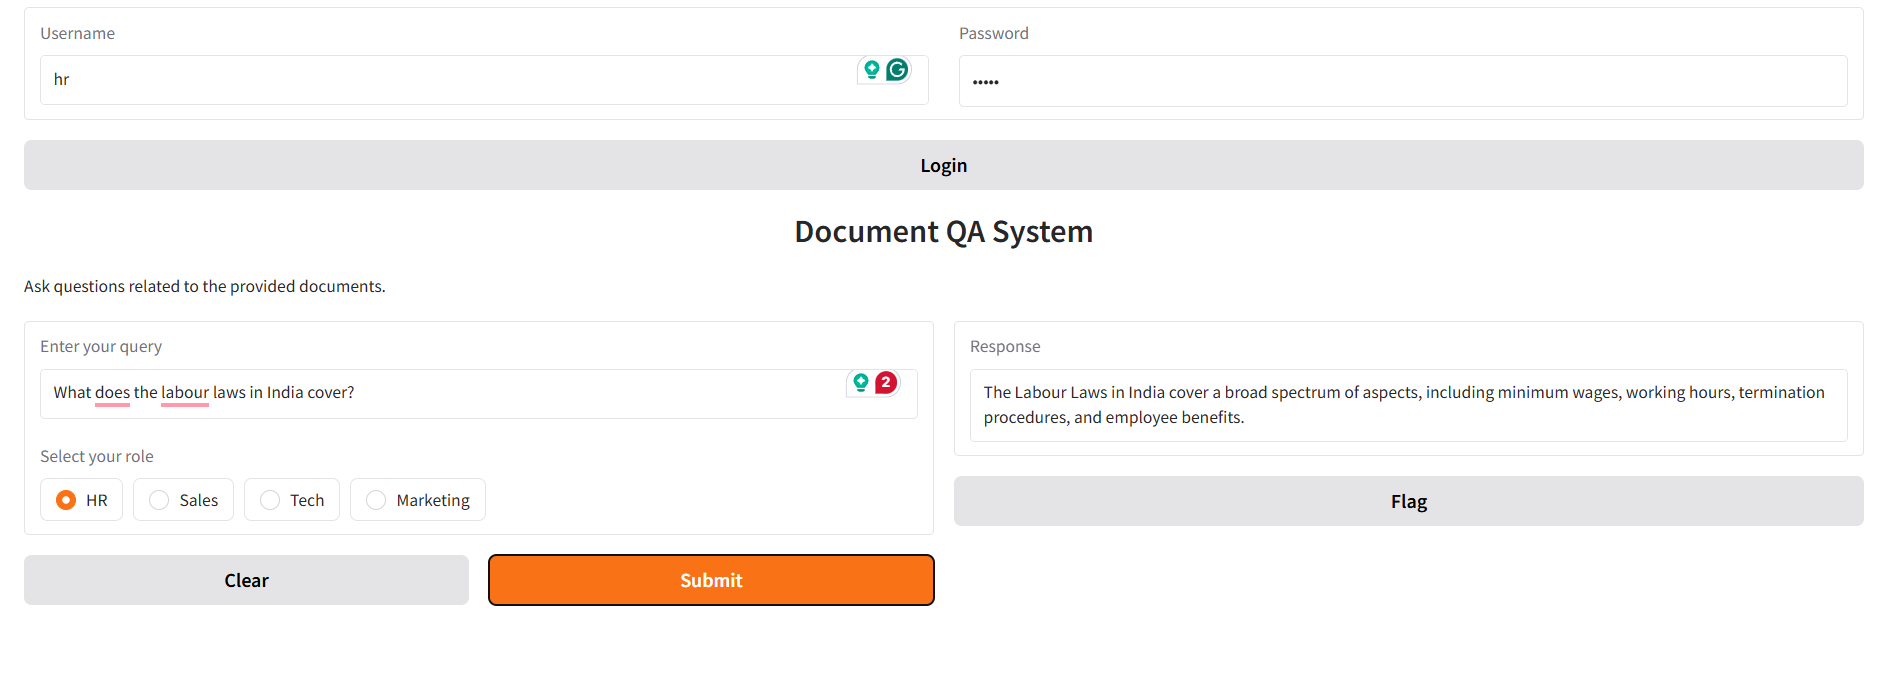

When The RBAC is changed to Sales it says , I cannot share the information

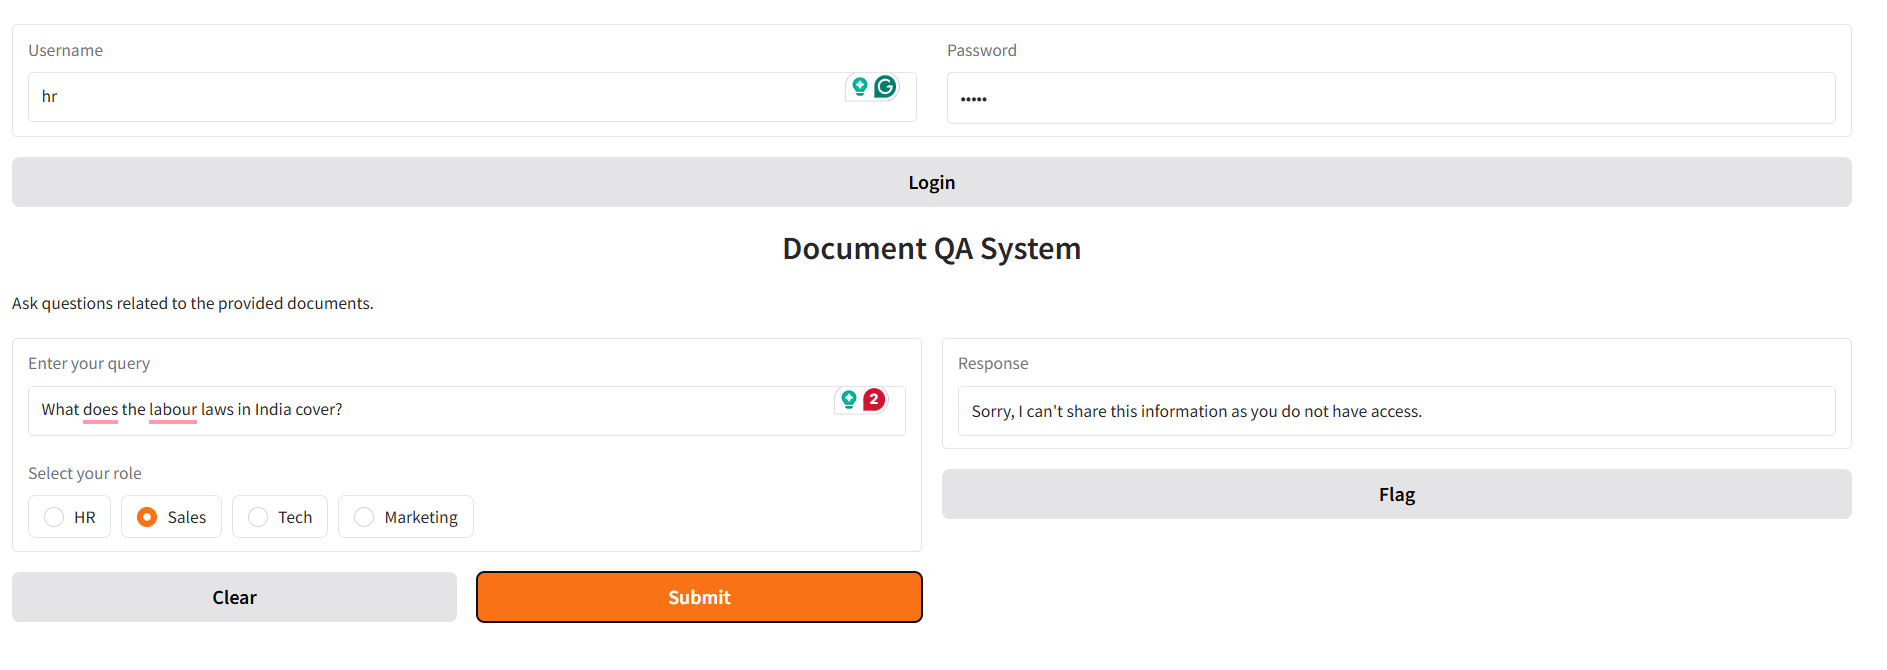

Example query to generate the email for compensation benifits query

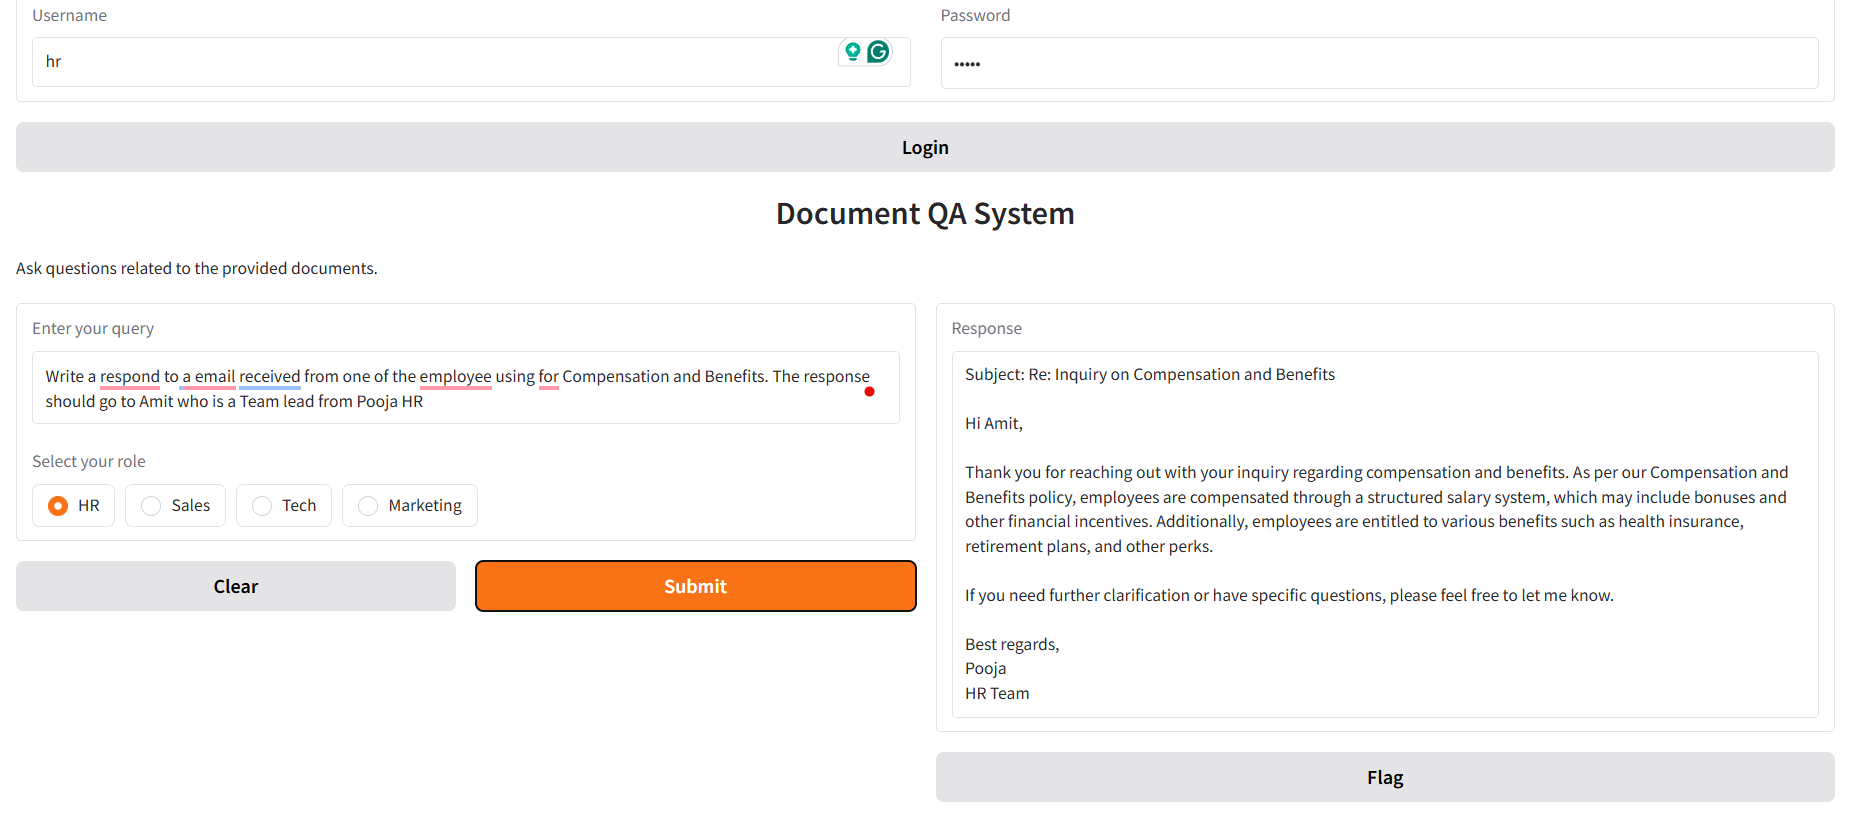

Reference- https://medium.com/@versatile_umber_ant_241/implementing-role-based-access-control-in-rag-de4a4e129215